# Il livello di istruzione degli individui non conta nel determinare la prosperità nazionale

Il progetto si focalizza sull'analisi della relazione tra istruzione e crescita
economica di un paese (dove per crescita economica si intende la capacità di produzione, più
in generale, di produrre ricchezza).

Comunemente si è portati a pensare che una forza lavoro ben istruita è un fattore
critico per lo sviluppo economico e ciò sarebbe dimostrabile dalla disparità tra il successo
economico dei paesi dell’Asia orientale, famosi per i loro alti livelli di istruzione, e la
stagnazione dei paesi dell’Africa subsahariana, che hanno livelli di istruzione tra i più bassi
al mondo. Inoltre, l’ascesa dell’economia della conoscenza, in cui la conoscenza è diventata
la principale fonte di ricchezza, ha reso l’istruzione, soprattutto quella universitaria, la vera
chiave della prosperità.

Tuttavia, sono scarse le prove che più istruzione renda un paese più ricco. Gran parte del
"know-how" acquisito tramite l’istruzione in realtà non è determinante per l’incremento
di produttività, anche se permette alla popolazione di avere una vita più soddisfacente e
indipendente.

Inoltre, l’opinione che il sorgere dell’economia basata sulla conoscenza abbia determinato
un aumento significativo del peso dell’istruzione può risultare fuorviante. Infatti, anche
quando si tratta di educazione universitaria (che si suppone ancora più importante in
un’economia della conoscenza) non c’è una rapporto automatico tra sapere e crescita economica.


Riassumendo, l’obiettivo del progetto è dimostrare che il livello di istruzione degli individui
non conta nel determinare la prosperità nazionale.

## Import librerie

In [379]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sklearn
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, cohen_kappa_score, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib
import math
import statsmodels.api as sm
from sklearn import linear_model



plt.style.use('seaborn-colorblind')

## Creazione dataset

### Durata media del periodo scolastico (Years of schooling)

Dati ottenuti da [Our World in Data](https://ourworldindata.org/global-education#years-of-schooling)

Dataset "Average Total Years of Schooling for Adult Population (Lee-Lee (2016), Barro-Lee (2018) and UNDP (2018))"

The average number of years spent in school are another common measure of a population’s education level. It is a helpful measure, because it allows aggregation of attainment across education levels. This allows an analysis of the ‘stock of human capital’ that a population has at any given point in time.

Average, or mean years of schooling of a population, are typically calculated from data on (i) the distribution of the population by age group and highest level of education attained in a given year; and (ii) the official duration of each level of education.

Struttura: **Entity** (paese) - **Year** - **Average total years of schooling**

E' presente un campionamento ogni 5 anni fino al 1990 poi uno ogni anno fino al 2017

In [296]:
uri = "/dataset/YearsOfSchooling.csv"

### Tasso di alfabetizzazione

Dati ottenuti da [Our World in Data](https://ourworldindata.org/global-education#how-is-literacy-distributed-across-the-globe)

Tuttavia non sono presenti dati per il Nord America e per i paesi dell'Europa dell'ovest in quanto utilizzano altre prove per stimare il tasso di alfabetizzazione e quest'ultime non sono comparabili internazionalmente.

Vanno controllati i dati mancanti (molti) per i paesi e in caso possibile andreppe effettuata un'interpolazione per generare i dati mancanti. 

**DA VALUTARE SE INSERIRE**

### Percentuale di studenti (primary) che dovrebbero essere in primary

Dati ottenuti da [Our World In Data]()

## Dataset Barro e Lee (v. 2.2 - 2018)

Dopo vari tentativi, scontrandosi con un problema costante di dati mancanti ed un problema di divisione dei paesi (area geografica - income - metodo Pritchet) si è scelto di partire dal dataset [Barro e Lee](http://www.barrolee.com/) il quale assicura un buon punto di partenza con dati educativi quantitativi di 24 paesi considerati avanzati e 122 paesi in via di sviluppo (suddivisi ulteriormente in 6 grandi aree geografiche). A questo dataset si andranno poi ad aggiungere per i paesi in questione altri indicatori qualitativi e indicatori economici preservando i raggruppamenti effettuati dagli autori del dataset.

In [297]:
base_url = "dataset/"

df = pd.read_excel(base_url + 'barroAndLee.xlsx')
df.head()

,Country,Year,NoSchooling,PrimaryTotal,SecondaryTotal,TertiaryTotal,AvgYearsOfTotalSchooling,Population(+15),Region
0,Australia,1950,1.27,44.79,43.17,10.77,8.04,6040,Advanced Economies
1,Australia,1955,1.12,40.63,46.57,11.69,8.27,6533,Advanced Economies
2,Australia,1960,0.96,36.52,49.91,12.60,8.53,7183,Advanced Economies
3,Australia,1965,0.80,31.30,53.69,14.21,8.93,8105,Advanced Economies
4,Australia,1970,0.76,23.73,56.25,19.26,9.70,9057,Advanced Economies


In [298]:
print(df.isna().sum())

Country                     0
Year                        0
NoSchooling                 0
PrimaryTotal                0
SecondaryTotal              0
TertiaryTotal               0
AvgYearsOfTotalSchooling    0
Population(+15)             0
Region                      0
dtype: int64


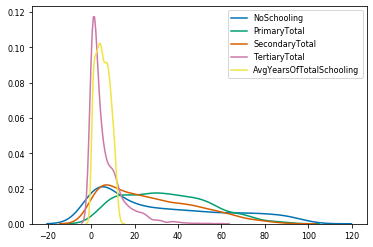

In [299]:
#df.groupby(["Country"]).mean()
sns.kdeplot(df["NoSchooling"])
sns.kdeplot(df["PrimaryTotal"])
sns.kdeplot(df["SecondaryTotal"])
sns.kdeplot(df["TertiaryTotal"])
sns.kdeplot(df["AvgYearsOfTotalSchooling"])

### Posizione TIMSS - 2019

Il Trends in International Mathematics and Science Study (TIMSS) dell'AIE è una serie di valutazioni internazionali delle conoscenze matematiche e scientifiche degli studenti di tutto il mondo è viene utilizzato come indicatore qualitativo della didattica. Gli studenti partecipanti provengono da una serie diversificata di sistemi educativi in termini di sviluppo economico, posizione geografica e dimensione della popolazione. In ciascuno dei sistemi educativi partecipanti, viene valutato un minimo di 4.000-5.000 studenti.

In [300]:
df_timss = pd.read_excel(base_url + 'timss19.xlsx')
df_timss.head()

,Country,m8,s8,m4,s4
0,Singapore,616.0,608.0,625.0,595.0
1,Taiwan,612.0,574.0,599.0,558.0
2,Hong Kong,578.0,504.0,602.0,531.0
3,South Korea,607.0,561.0,600.0,588.0
4,Japan,594.0,570.0,593.0,562.0


Essendo due dataset differenti i nomi dei paesi potrebbe differire, per evitare ciò si va a visualizzare i paesi del secondo dataset non presenti nel primo, così è possibile effettuare un check manuale ed evitare errori o perdite di dati

In [301]:
for i in range(len(df_timss["Country"])):
    if(df_timss.iloc[i]["Country"] in set(df["Country"])):
        # print(df_timss.iloc[i]["Country"] + " è presente")
        pass
    else:
        print(df_timss.iloc[i]["Country"] + " non è presente")

Northern Ireland non è presente
Georgia non è presente
Azerbaijan non è presente
Bosnia and Herzegovina non è presente
North Macedonia non è presente
Montenegro non è presente
Kosovo non è presente
Oman non è presente
Lebanon non è presente


Check nomi dei paesi per ogni file contenente timss (edizioni dal 2019 al 1995).

In [302]:
timss = ["timss19.xlsx", "timss15.xlsx", "timss11.xlsx", "timss07.xlsx", "timss03.xlsx", "timss99.xlsx", "timss95.xlsx"]
for filename in timss:
        actual_df = pd.read_excel(base_url + filename)
        actual_df_len = len(actual_df["Country"])
        
        for i in range(actual_df_len):
            if not(actual_df.iloc[i]["Country"] in set(df["Country"])):
                print("[" + filename + "] " + actual_df.iloc[i]["Country"] + " non è presente")

[timss19.xlsx] Northern Ireland non è presente
[timss19.xlsx] Georgia non è presente
[timss19.xlsx] Azerbaijan non è presente
[timss19.xlsx] Bosnia and Herzegovina non è presente
[timss19.xlsx] North Macedonia non è presente
[timss19.xlsx] Montenegro non è presente
[timss19.xlsx] Kosovo non è presente
[timss19.xlsx] Oman non è presente
[timss19.xlsx] Lebanon non è presente
[timss15.xlsx] Northern Ireland non è presente
[timss15.xlsx] Georgia non è presente
[timss15.xlsx] Oman non è presente
[timss15.xlsx] Lebanon non è presente
[timss11.xlsx] Northern Ireland non è presente
[timss11.xlsx] Georgia non è presente
[timss11.xlsx] Azerbaijan non è presente
[timss11.xlsx] Oman non è presente
[timss11.xlsx] Lebanon non è presente
[timss11.xlsx] Macedonia non è presente
[timss11.xlsx] Syria non è presente
[timss11.xlsx] Palestine non è presente
[timss07.xlsx] Scotland non è presente
[timss07.xlsx] Georgia non è presente
[timss07.xlsx] Bosnia and Herzegovina non è presente
[timss07.xlsx] Lebano

A questo punto vanno aggiunte le informazioni riguardante il punteggio timss di ogni paese in ogni edizione nel dataset primario. Tuttavia, il dataset primario (Barro and Lee) presenta campioni per paese ogni 5 anni il che risulta discrepante con le varie edizione in cui è presente un valore timss. Si è quindi deciso di procedere ritenendo valido l'ultimo punteggio più recente dello stato partecipante al timss per ogni campionamento quinquennale del dataset primario.

In [303]:
timss = ["timss07.xlsx", "timss03.xlsx", "timss99.xlsx", "timss95.xlsx"]

################### prova procedurale #########################

#df_07 = pd.read_excel(base_url + "timss07.xlsx")
#df_07["Year"] = 2010
# len07 = len(df_07)

# for i in range(len07):
#    row = df_07.iloc[i]
#    if(row["Country"] in set(df["Country"])):
#       df.loc[:, (df["Year"] == 2010) & (df["Country"] == row["Country"])]["m8"] = row["m8"]


# df = df.merge(df_07, how='left', on = ['Country', 'Year'])






################################################################


df["m8"] = np.nan
df["s8"] = np.nan
df["m4"] = np.nan
df["s4"] = np.nan

correspondent_year = {
                                "timss07.xlsx" : 2010,
                                "timss03.xlsx" : 2005,
                                "timss99.xlsx" : 2000,
                                "timss95.xlsx" : 1995
                      }

for filename in timss: 
        print("############### Processing: " + base_url + filename)
        actual_df = pd.read_excel(base_url + filename)
        #actual_df["Year"] = correspondent_year[filename]
        actual_df_len = len(actual_df)
        # print("Length: " + str(actual_df_len))
        #print(actual_df.head())
        
        for i in range(actual_df_len):
            row = actual_df.iloc[i]
            # print("Processing row " + str(i) + ", country " + row["Country"])
            if(row["Country"] in set(df["Country"])):
                # print(row["Country"] + " è presente nel dataset Barro e Lee")
                m8 = (actual_df[actual_df["Country"] == row["Country"]]["m8"]).values[0]
                s8 = (actual_df[actual_df["Country"] == row["Country"]]["s8"]).values[0]
                m4 = (actual_df[actual_df["Country"] == row["Country"]]["m4"]).values[0]
                s4 = (actual_df[actual_df["Country"] == row["Country"]]["s4"]).values[0]
                # print(m8)
                # print(s8)
                # print(m4)
                # print(s4)

                values = {"m8": m8, "s8": s8, "m4": m4, "s4": s4}                
                df.loc[(df["Year"] == correspondent_year[filename]) & (df["Country"] == row["Country"])] = df[(df["Year"] == correspondent_year[filename]) & (df["Country"] == row["Country"])].fillna(value=values)
                
        
        # print(df[(df["Year"] == correspondent_year[filename]) & (df["Country"] == actual_df.iloc[i]["Country"])])
        
        
        #print(df.head())
        # df = df.merge(actual_df, how='outer', on = ['Country', 'Year'])
        # print(df.head())
        
        # df_semi_merged = df[df["Year"] == correspondent_year[filename]].merge(actual_df, how='inner', on='Country')
        
        # print(df_semi_merged.head())
        
        # df[df["Year"] == correspondent_year[filename]] = df_semi_merged
        
        
                #df[(df["Year"] == correspondent_year[filename]) & (df["Country"] == actual_df.iloc[i]["Country"])]["m8"].fillna(actual_df["m8"])

                
                #df.loc[:, (df["Country"] == actual_df.iloc[i]["Country"]) & (df["Year"] == correspondent_year[filename])]) = ["m8-" + str(correspondent_year[filename])] = actual_df.iloc[i]["m8"]
                
                # df.loc[(df["Country"] == actual_df.iloc[i]["Country"]) & (df["Year"] == correspondent_year[filename])]["m8-" + str(correspondent_year[filename])] = actual_df.iloc[i]["m8"]
    
                #print(df.query("'Country' == " + actual_df.iloc[i]["Country"] + "  and 'Year' == " + str(correspondent_year[filename])))
            
                #print(df.loc(
                #    (df["Country"] == actual_df.iloc[i]["Country"]) & 
                #    (df["Year"] == correspondent_year[filename])))
                #["m8-" + str(correspondent_year[filename])] = actual_df.iloc[i]["m8"]
                
df.head()

############### Processing: dataset/timss07.xlsx
############### Processing: dataset/timss03.xlsx
############### Processing: dataset/timss99.xlsx
############### Processing: dataset/timss95.xlsx


,Country,Year,NoSchooling,PrimaryTotal,SecondaryTotal,TertiaryTotal,AvgYearsOfTotalSchooling,Population(+15),Region,m8,s8,m4,s4
0,Australia,1950,1.27,44.79,43.17,10.77,8.04,6040,Advanced Economies,NaN,NaN,NaN,NaN
1,Australia,1955,1.12,40.63,46.57,11.69,8.27,6533,Advanced Economies,NaN,NaN,NaN,NaN
2,Australia,1960,0.96,36.52,49.91,12.60,8.53,7183,Advanced Economies,NaN,NaN,NaN,NaN
3,Australia,1965,0.80,31.30,53.69,14.21,8.93,8105,Advanced Economies,NaN,NaN,NaN,NaN
4,Australia,1970,0.76,23.73,56.25,19.26,9.70,9057,Advanced Economies,NaN,NaN,NaN,NaN


### PISA test scores

Dati ottenuti da [OWID](https://github.com/owid/owid-datasets/blob/4c73a1d2b4723c5a85d2370ef41ecc026129e643/datasets/OECD%20Education!%20PISA%20Test%20Scores%20-%20PISA%20(2015)/OECD%20Education!%20PISA%20Test%20Scores%20-%20PISA%20(2015).csv)

I punteggi dei test di istruzione PISA (lettura, matematica e scienze). La variabile media PISA OCSE è la media dei punteggi di matematica, lettura e scienze. Tale valore viene utilizzato per creare una classifica generale.

In [304]:
df_pisa = pd.read_excel(base_url + 'pisa.xlsx')
df_pisa.head()

,Country,Year,Pisa
0,Albania,2000,369.0
1,Albania,2009,384.0
2,Albania,2012,395.0
3,Argentina,2000,401.0
4,Argentina,2006,382.0


In [305]:
df_pisa['Year'] = pd.to_datetime(df_pisa.Year, format='%Y')
df_pisa.head()
df_pisa.set_index(["Country", "Year"])

Pisa
Country   Year             
Albania   2000-01-01  369.0
          2009-01-01  384.0
          2012-01-01  395.0
Argentina 2000-01-01  401.0
          2006-01-01  382.0
...                     ...
Uruguay   2003-01-01  411.0
          2006-01-01  423.0
          2009-01-01  427.0
          2012-01-01  412.0
Vietnam   2012-01-01  516.0

[272 rows x 1 columns]

In [306]:
print(df_pisa.isna().sum())

Country    0
Year       0
Pisa       9
dtype: int64


In [307]:
df_pisa_len = len(df_pisa["Country"])
        
for i in range(df_pisa_len):
    if not(df_pisa.iloc[i]["Country"] in set(df["Country"])):
        print(df_pisa.iloc[i]["Country"] + " non è presente")
        df_pisa.drop(i, axis=0)

Azerbaijan non è presente
Azerbaijan non è presente
Liechtenstein non è presente
Liechtenstein non è presente
Liechtenstein non è presente
Liechtenstein non è presente
Liechtenstein non è presente
Macedonia non è presente
Macedonia non è presente
Macedonia non è presente
Macedonia non è presente
Macedonia non è presente
Montenegro non è presente
Montenegro non è presente
Montenegro non è presente


In [308]:
duemila = (df_pisa[df_pisa.Year.dt.year == 2000]).groupby(['Country'])['Pisa'].mean().reset_index()
duemila5 = (df_pisa[df_pisa.Year.dt.year.between(2001, 2005)]).groupby(['Country'])['Pisa'].mean().reset_index()
duemila10 = (df_pisa[df_pisa.Year.dt.year.between(2005, 2010)]).groupby(['Country'])['Pisa'].mean().reset_index()

In [309]:
df["Pisa"] = np.nan


for i in range(len(duemila)):
    row = duemila.iloc[i]
    if(row["Country"] in set(df["Country"])):
        values = {"Pisa": row["Pisa"]}
        df.loc[(df["Year"] == 2000) & (df["Country"] == row["Country"])] = df[(df["Year"] == 2000) & (df["Country"] == row["Country"])].fillna(value=values)

for i in range(len(duemila5)):
    row = duemila5.iloc[i]
    if(row["Country"] in set(df["Country"])):
        values = {"Pisa": row["Pisa"]}
        df.loc[(df["Year"] == 2005) & (df["Country"] == row["Country"])] = df[(df["Year"] == 2005) & (df["Country"] == row["Country"])].fillna(value=values)

        
for i in range(len(duemila10)):
    row = duemila10.iloc[i]
    if(row["Country"] in set(df["Country"])):
        values = {"Pisa": row["Pisa"]}
        df[(df["Year"] == 2010) & (df["Country"] == row["Country"])] = df[(df["Year"] == 2010) & (df["Country"] == row["Country"])].fillna(value=values)

        
df.head(50)

,Country,Year,NoSchooling,PrimaryTotal,SecondaryTotal,TertiaryTotal,AvgYearsOfTotalSchooling,Population(+15),Region,m8,s8,m4,s4,Pisa
0,Australia,1950,1.27,44.79,43.17,10.77,8.04,6040,Advanced Economies,NaN,NaN,NaN,NaN,NaN
1,Australia,1955,1.12,40.63,46.57,11.69,8.27,6533,Advanced Economies,NaN,NaN,NaN,NaN,NaN
2,Australia,1960,0.96,36.52,49.91,12.60,8.53,7183,Advanced Economies,NaN,NaN,NaN,NaN,NaN
3,Australia,1965,0.80,31.30,53.69,14.21,8.93,8105,Advanced Economies,NaN,NaN,NaN,NaN,NaN
4,Australia,1970,0.76,23.73,56.25,19.26,9.70,9057,Advanced Economies,NaN,NaN,NaN,NaN,NaN
5,Australia,1975,1.07,12.75,65.46,20.72,10.52,9865,Advanced Economies,NaN,NaN,NaN,NaN,NaN
6,Australia,1980,0.80,6.10,69.90,23.20,11.20,10937,Advanced Economies,NaN,NaN,NaN,NaN,NaN
7,Australia,1985,1.12,7.80,67.54,23.48,11.20,11973,Advanced Economies,NaN,NaN,NaN,NaN,NaN
8,Australia,1990,1.09,9.25,65.33,24.33,11.18,13178,Advanced Economies,NaN,NaN,NaN,NaN,NaN
9,Australia,1995,1.37,10.81,60.35,27.47,11.20,14009,Advanced Economies,530.0,545.0,546.0,562.0,NaN


### Spesa in educazione (% del pil)

Dati ottenuti da [Wordl Bank Data](https://data.worldbank.org/indicator/SE.XPD.TOTL.GD.ZS)

+ Our world in data https://nces.ed.gov/pubs2016/2016014.pdf
+ Education For All In India https://www.educationforallinindia.com/selected-educational-statistics-2000-2001.pdf

Contiene la spesa in educazione come percentuale del PIL di ogni paese, sono presenti dati dal 1970 al 2010.

Al fine di ottenere dati continui nell'intervallo '1970-'2010 si seleziona per ogni campione di ogni 5 anni il valore dell'anno corretto (se presente) altrimenti il più recente nel quinquennio precedente.

In [310]:
df_edu = pd.read_excel(base_url + 'educationalExpenditure.xlsx')
df_edu.head()

,Country,1970 [YR1970],1971 [YR1971],1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010]
0,Afghanistan,NaN,1.16036,1.11718,1.42788,NaN,1.30332,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.57000,2.90000,2.85000,3.51000,3.73000,3.479450
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.4587,3.11780,3.13823,3.22752,3.28155,3.19146,3.27593,NaN,NaN,3.413075
2,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.62000,4.96000,4.33702,6.03000,NaN
3,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14.71705,NaN,NaN,NaN,NaN
4,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.65971,NaN,1.54412,1.64497,2.24490,2.10469,2.87393,3.14292,2.976630


In [311]:
def get_new_name(old_name):
    if old_name == "Country":
        return old_name
    return old_name[:len(old_name) - 8]

for column in df_edu.columns.values:
    new_name = get_new_name(column)
    if(new_name == "Country"):
        continue
    df_edu[new_name] = df_edu[column]
    df_edu = df_edu.drop(column, axis=1)

    
df_edu.head()

,Country,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,Afghanistan,NaN,1.16036,1.11718,1.42788,NaN,1.30332,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.57000,2.90000,2.85000,3.51000,3.73000,3.479450
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.4587,3.11780,3.13823,3.22752,3.28155,3.19146,3.27593,NaN,NaN,3.413075
2,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.62000,4.96000,4.33702,6.03000,NaN
3,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14.71705,NaN,NaN,NaN,NaN
4,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.65971,NaN,1.54412,1.64497,2.24490,2.10469,2.87393,3.14292,2.976630


In [312]:
df_edu_2 = pd.DataFrame()
number_of_years = len(df_edu.columns) - 1

for i in range(len(df_edu)):
    # salvo la riga attuale
    current_row = df_edu.iloc[i]
        # la elimino dal dataset utilizzato l'index e axis = 0
        #df_edu = df_edu.drop(i)
    # creo la series Country * 40
    country = pd.Series([current_row["Country"]] * number_of_years)
    # creo la series Year = np.arange
    year = pd.Series(np.arange(1970, 2011, 1, dtype=int).tolist())
    # creo la series eduExpenditure copiando la riga attuale (eliminata)
    eduExp = []
    for j in range(len(current_row)):
        if j == 0:
            continue
        else:
            eduExp.append(current_row[j])
    eduExp_s = pd.Series(eduExp)
    # creo un dataframe con specificando nomi e series  (le tre precedenti)
    df_partial = pd.DataFrame({"Country": country, "Year": year, "EduExp": eduExp_s})
    df_partial.reset_index(drop=True, inplace=True)
    # concateno il dataframe a df_edu_2
    df_edu_2 = pd.concat([df_edu_2, df_partial])
    
df_edu_2.head()


,Country,Year,EduExp
0,Afghanistan,1970,NaN
1,Afghanistan,1971,1.16036
2,Afghanistan,1972,1.11718
3,Afghanistan,1973,1.42788
4,Afghanistan,1974,NaN


In [313]:
def get_most_recent_value(ds, country, year, feature):
    i_year = int(year)
    most_recent = np.nan
    lower_limit = 1970
    while((i_year > int(year) - 5) and (i_year > 1970) and (math.isnan(most_recent))):
        most_recent = ds[(ds["Country"] == country) & (ds["Year"] == (i_year - 1))][feature].values[0]
        i_year -= 1
    return most_recent

In [314]:
years = ["1970", "1975", "1980", "1985", "1990", "1995", "2000", "2005", "2010"]
countries = df_edu_2["Country"].unique()
df["EducationalExpenditure"] = np.nan

for country in countries:
    if(country in set(df["Country"])):
        for year in years:
            #print("## Parsing " + country + " " + year)
            selected_value = df_edu_2[(df_edu_2["Country"] == country) & (df_edu_2["Year"] == int(year))]["EduExp"].values[0]
            if(math.isnan(selected_value)):
                selected_value = get_most_recent_value(df_edu_2, country, year, "EduExp")
            values = {"EducationalExpenditure": float(selected_value)}
            df[(df["Year"] == int(year)) & (df["Country"] == country)] = df[(df["Year"] == int(year)) & (df["Country"] == country)].fillna(value=values)
    else:
        print(country + " non è presente")
    


American Samoa non è presente
Andorra non è presente
Angola non è presente
Antigua and Barbuda non è presente
Aruba non è presente
Azerbaijan non è presente
Bahamas, The non è presente
Belarus non è presente
Bermuda non è presente
Bhutan non è presente
Bosnia and Herzegovina non è presente
British Virgin Islands non è presente
Burkina Faso non è presente
Cabo Verde non è presente
Cayman Islands non è presente
Chad non è presente
Channel Islands non è presente
Comoros non è presente
Curacao non è presente
Djibouti non è presente
Dominica non è presente
Equatorial Guinea non è presente
Eritrea non è presente
Eswatini non è presente
Ethiopia non è presente
Faroe Islands non è presente
French Polynesia non è presente
Georgia non è presente
Gibraltar non è presente
Greenland non è presente
Grenada non è presente
Guam non è presente
Guinea non è presente
Guinea-Bissau non è presente
Isle of Man non è presente
Kiribati non è presente
Kosovo non è presente
Kyrgyz Republic non è presente
Lebano

In [315]:
df.head(30)

,Country,Year,NoSchooling,PrimaryTotal,SecondaryTotal,TertiaryTotal,AvgYearsOfTotalSchooling,Population(+15),Region,m8,s8,m4,s4,Pisa,EducationalExpenditure
0,Australia,1950,1.27,44.79,43.17,10.77,8.04,6040,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,1955,1.12,40.63,46.57,11.69,8.27,6533,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN
2,Australia,1960,0.96,36.52,49.91,12.60,8.53,7183,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN
3,Australia,1965,0.80,31.30,53.69,14.21,8.93,8105,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN
4,Australia,1970,0.76,23.73,56.25,19.26,9.70,9057,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN
5,Australia,1975,1.07,12.75,65.46,20.72,10.52,9865,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN
6,Australia,1980,0.80,6.10,69.90,23.20,11.20,10937,Advanced Economies,NaN,NaN,NaN,NaN,NaN,5.64446
7,Australia,1985,1.12,7.80,67.54,23.48,11.20,11973,Advanced Economies,NaN,NaN,NaN,NaN,NaN,5.39562
8,Australia,1990,1.09,9.25,65.33,24.33,11.18,13178,Advanced Economies,NaN,NaN,NaN,NaN,NaN,4.66854
9,Australia,1995,1.37,10.81,60.35,27.47,11.20,14009,Advanced Economies,530.0,545.0,546.0,562.0,NaN,5.13413


### Crescita economica

Come valori di crescita economica sono tenuti in considerazione i seguenti fattori:

- **GDP pro capite**: GDP pro capite calcolato utilizzando il valore GDP reale di ogni anno calcolato con anno base 2017 (applicando i prezzi dell'anno base 2017 alla produzione dell'anno in considerazione) e la relativa numerosità della popolazione.
- **GDP per lavoratore**: GDP pro capite calcolato utilizzando il valore GDP reale di ogni anno calcolato con anno base 2017 (applicando i prezzi dell'anno base 2017 alla produzione dell'anno in considerazione) e la relativa numerosità della popolazione occupata.
- **GDP per ora lavorata**: GDP per lavoratore diviso il numero medio di ore lavorate annuali

I dati di riferimento sono calcolati partendo dai dati forniti da [Penn World Table](https://www.rug.nl/ggdc/productivity/pwt/)

- RGDPNA - rgdpna	Real GDP at constant 2017 national prices (in mil. 2017US$)
- POP - pop	Population (in millions)
- EMP - emp	Number of persons engaged (in millions)
- AVH - avh	Average annual hours worked by persons engaged

Il dataset pwt contiene dati per 183 nazioni con dati annuali dal 1950 al 2019.


In [316]:
df_eco = pd.read_excel(base_url + "economicGrowth_2.xlsx")
countries = df_eco["Country"].unique()
before = len(countries)

for country in countries:
    if(country not in set(df["Country"])):
        df_eco = df_eco.drop(df_eco[df_eco["Country"] == country].index)

df_eco = df_eco.drop(df_eco[df_eco["Year"] > 2010].index)
        
after = len(df_eco["Country"].unique())
years_after = len(df_eco["Year"].unique())
        
print("Countries before: " + str(before) + " countries after: " + str(after))
print("Years: " + str(years_after))

Countries before: 183 countries after: 139
Years: 61


In [317]:
years = ["1950", "1955", "1960", "1965", "1970", "1975", "1980", "1985", "1990", "1995", "2000", "2005", "2010"]
features = ["Rgdpna", "Pop", "Emp", "Avh"]
countries = df_eco["Country"].unique()

for feature in features:
    for country in countries:
        for year in years:
            selected_value = df_eco[(df_eco["Country"] == country) & (df_eco["Year"] == int(year))][feature].values[0]
            if(math.isnan(selected_value)):
                selected_value = get_most_recent_value(df_eco, country, year, feature)
            df_eco.loc[df_eco[(df_eco["Country"] == country) & (df_eco["Year"] == int(year))].index][feature] = float(selected_value)

In [318]:
df_eco["GDPcapita"] = df_eco["Rgdpna"] / df_eco["Pop"]
df_eco["GDPworker"] = df_eco["Rgdpna"] / df_eco["Emp"]
df_eco["GDPhour"] = df_eco["GDPworker"] / df_eco["Avh"]
df_eco["TotalPop"] = df_eco["Pop"]
df_eco["Employed"] = df_eco["Emp"]

df_eco.head(50)

,Country,Year,Rgdpna,Pop,Emp,Avh,GDPcapita,GDPworker,GDPhour,TotalPop,Employed
210,Albania,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,Albania,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,Albania,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,Albania,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,Albania,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,Albania,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,Albania,1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,Albania,1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,Albania,1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,Albania,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [321]:
features = ["GDPcapita", "GDPworker", "GDPhour", "TotalPop", "Employed"]

df["GDPcapita"] = np.nan
df["GDPworker"] = np.nan
df["GDPhour"] = np.nan
df["TotalPop"] = np.nan
df["Employed"] = np.nan

for feature in features:
    for country in countries:
        for year in years:
            selected_value = df_eco[(df_eco["Country"] == country) & (df_eco["Year"] == int(year))][feature].values[0]
            values = {feature: float(selected_value)}
            df[(df["Year"] == int(year)) & (df["Country"] == country)] = df[(df["Year"] == int(year)) & (df["Country"] == country)].fillna(value=values)
            
            
# Cuba GDP at 2015 -
selected_value = [np.nan, np.nan, np.nan, np.nan, 2606.0, 3163.0, 3605.0, 5250.0, 4964.0, 3349.0, 4113.0, 5190.0, 6721.0]
#df_eco.loc[df_eco[(df_eco["Country"] == "Cuba")].index]["GDPcapita"] = float(selected_value)
df.loc[df['Country'] == "Cuba", "GDPcapita"] = selected_value

In [322]:
df.head(50)

,Country,Year,NoSchooling,PrimaryTotal,SecondaryTotal,TertiaryTotal,AvgYearsOfTotalSchooling,Population(+15),Region,m8,s8,m4,s4,Pisa,EducationalExpenditure,GDPcapita,GDPworker,GDPhour,TotalPop,Employed
0,Australia,1950,1.27,44.79,43.17,10.77,8.04,6040,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN,15259.086802,37166.394765,17.120086,8.354106,3.429873
1,Australia,1955,1.12,40.63,46.57,11.69,8.27,6533,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN,16640.738601,40930.441962,19.750447,9.374454,3.811291
2,Australia,1960,0.96,36.52,49.91,12.60,8.53,7183,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN,17696.365472,44588.050222,22.538445,10.470019,4.155402
3,Australia,1965,0.80,31.30,53.69,14.21,8.93,8105,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN,20035.701796,49439.182472,25.222402,11.559446,4.684576
4,Australia,1970,0.76,23.73,56.25,19.26,9.70,9057,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN,24160.248069,56497.996139,29.090949,12.793034,5.470687
5,Australia,1975,1.07,12.75,65.46,20.72,10.52,9865,Advanced Economies,NaN,NaN,NaN,NaN,NaN,NaN,25899.661722,60732.463913,32.068586,13.773288,5.873687
6,Australia,1980,0.80,6.10,69.90,23.20,11.20,10937,Advanced Economies,NaN,NaN,NaN,NaN,NaN,5.64446,28314.323087,65800.057536,34.454570,14.588405,6.277514
7,Australia,1985,1.12,7.80,67.54,23.48,11.20,11973,Advanced Economies,NaN,NaN,NaN,NaN,NaN,5.39562,30510.679399,71523.833504,38.263176,15.663663,6.681815
8,Australia,1990,1.09,9.25,65.33,24.33,11.18,13178,Advanced Economies,NaN,NaN,NaN,NaN,NaN,4.66854,32738.451807,70774.945571,37.970211,16.960597,7.845484
9,Australia,1995,1.37,10.81,60.35,27.47,11.20,14009,Advanced Economies,530.0,545.0,546.0,562.0,NaN,5.13413,36156.460814,79187.830517,42.338971,17.993074,8.215478


In [323]:
df.groupby(["Country"]).describe()

Year                                                             \
            count    mean        std     min     25%     50%     75%     max   
Country                                                                        
Afghanistan  13.0  1980.0  19.472202  1950.0  1965.0  1980.0  1995.0  2010.0   
Albania      13.0  1980.0  19.472202  1950.0  1965.0  1980.0  1995.0  2010.0   
Algeria      13.0  1980.0  19.472202  1950.0  1965.0  1980.0  1995.0  2010.0   
Argentina    13.0  1980.0  19.472202  1950.0  1965.0  1980.0  1995.0  2010.0   
Armenia      13.0  1980.0  19.472202  1950.0  1965.0  1980.0  1995.0  2010.0   
...           ...     ...        ...     ...     ...     ...     ...     ...   
Venezuela    13.0  1980.0  19.472202  1950.0  1965.0  1980.0  1995.0  2010.0   
Vietnam      13.0  1980.0  19.472202  1950.0  1965.0  1980.0  1995.0  2010.0   
Yemen        13.0  1980.0  19.472202  1950.0  1965.0  1980.0  1995.0  2010.0   
Zambia       13.0  1980.0  19.472202  1950.0  1965.0  1980.0  1995.0  2010.0   
Zimbabwe     13.0  1980.0  19.472202  1950.0  1965.0  1980.0  1995.0  2010.0   

            NoSchooling             ...   TotalPop            Employed  \
                  count       mean  ...        75%        max    count   
Country                             ...                                  
Afghanistan        13.0  80.650769  ...        NaN        NaN      0.0   
Albania            13.0  23.845385  ...   3.112936   3.286073      9.0   
Algeria            13.0  55.043077  ...  29.900010  35.977455     11.0   
Argentina          13.0   6.310000  ...  34.828170  40.895752     13.0   
Armenia            13.0   3.184615  ...   3.217348   3.538171      5.0   
...                 ...        ...  ...        ...        ...      ...   
Venezuela          13.0  25.693077  ...  21.931084  28.439940     13.0   
Vietnam            13.0  26.106154  ...  79.910412  87.967651      9.0   
Yemen              13.0  87.476923  ...  20.107409  23.154855      5.0   
Zambia             13.0  36.070769  ...   9.426441  13.605984     12.0   
Zimbabwe           13.0  27.261538  ...  11.528405  12.697723     12.0   

                                                                               \
                  mean        std        min        25%        50%        75%   
Country                                                                         
Afghanistan        NaN        NaN        NaN        NaN        NaN        NaN   
Albania       1.009908   0.165452   0.769157   0.892909   1.013384   1.027045   
Algeria       4.584095   2.653587   1.958112   2.225032   4.094855   5.944949   
Argentina    10.693170   3.452657   6.608833   8.140460   9.828572  11.835314   
Armenia       1.460670   0.300692   1.160065   1.190184   1.418874   1.701637   
...                ...        ...        ...        ...        ...        ...   
Venezuela     5.434020   3.383298   1.688439   2.709409   4.635100   7.667000   
Vietnam      30.315967  11.147331  15.576067  22.064880  29.049198  37.051804   
Yemen         3.307538   0.825545   2.148016   2.899534   3.408885   3.785651   
Zambia        2.030872   0.896504   0.927291   1.281637   1.879186   2.604835   
Zimbabwe      3.584659   1.555437   1.517789   2.190649   3.481282   5.055498   

                        
                   max  
Country                 
Afghanistan        NaN  
Albania       1.324078  
Algeria       9.781852  
Argentina    18.076746  
Armenia       1.832591  
...                ...  
Venezuela    12.009800  
Vietnam      49.048500  
Yemen         4.295603  
Zambia        3.704170  
Zimbabwe      5.753274  

[146 rows x 144 columns]

## Salvataggio dataset 

In [324]:
df.to_excel(base_url + 'final_dataset.xlsx', index=False)

In [325]:
df = pd.read_excel(base_url + "final_dataset.xlsx")
print(df.isna().sum())

Country                        0
Year                           0
NoSchooling                    0
PrimaryTotal                   0
SecondaryTotal                 0
TertiaryTotal                  0
AvgYearsOfTotalSchooling       0
Population(+15)                0
Region                         0
m8                          1738
s8                          1738
m4                          1815
s4                          1815
Pisa                        1763
EducationalExpenditure      1072
GDPcapita                    377
GDPworker                    463
GDPhour                     1272
TotalPop                     386
Employed                     463
dtype: int64


In [326]:
df.groupby(["Region"]).mean().isna().sum()

Year                        0
NoSchooling                 0
PrimaryTotal                0
SecondaryTotal              0
TertiaryTotal               0
AvgYearsOfTotalSchooling    0
Population(+15)             0
m8                          1
s8                          1
m4                          2
s4                          2
Pisa                        2
EducationalExpenditure      0
GDPcapita                   0
GDPworker                   0
GDPhour                     0
TotalPop                    0
Employed                    0
dtype: int64

### Problema dei valori NaN

Eliminare gli anni senza dati per ogni paese potrebbe creare un dataset con serie storiche sfalzate nel tempo. Questo potrebbe influenzare i risultati di una regressione multivariata e potrebbe portare a interpretazioni errate o bias nei risultati.

Quando si costruisce una regressione multivariata, è importante che le serie storiche siano allineate nel tempo in modo coerente per evitare distorsioni nei coefficienti stimati e nelle relazioni tra le variabili. Se si elimina gli anni mancanti per ogni paese, si potrebbe avere un numero diverso di osservazioni per ogni paese nel corso del tempo. Ciò può causare problemi nella stima dei coefficienti e nella validità delle conclusioni.

Una possibile soluzione potrebbe essere considerare l'interpolazione dei dati mancanti. Si possono utilizzare tecniche di interpolazione per stimare i valori mancanti in base ai valori vicini nel tempo o utilizzando modelli predittivi. Questo aiuterebbe a mantenere l'allineamento temporale delle serie storiche e potrebbe fornire una rappresentazione più coerente dei dati nel tempo.

Tuttavia, è importante notare che l'interpolazione introduce un certo grado di incertezza e potrebbe influenzare i risultati dell'analisi. 

Al fine di scegliere le gisute modalità di selezione dei dati che poi influiranno sulla scelta del modello e dello studio statistico, si procede analizzando i valori NaN nei seguenti modi:

- analisi per anno: percentuale di valori NaN per ogni campionamento (valutando se le istanze precedenti al 1970 sono utili)
- analisi per feature: percentuale di valori NaN per ogni colonna
- analisi per paese: percentuale valori NaN per ogni paese
- analisi per regione, al fine di valutare se un'analisi generale delle aree geografiche ha senso o meno


In [327]:
df_ = df.copy()

### Analisi per feature

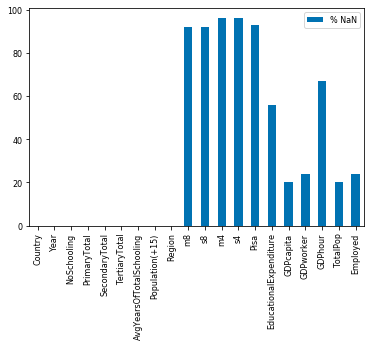

In [328]:
x_features = (round(df_.isna().sum() / df_.shape[0] * 100), 2)


df_feature = pd.DataFrame(x_features[0], columns=['% NaN'])
df_feature.head()
df_feature.plot(kind='bar')

#### Dal 1970 in poi

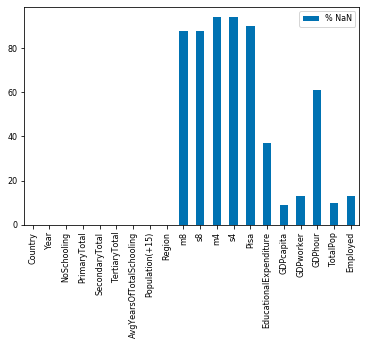

In [329]:
df_after_1970 = df_.loc[df_[df_["Year"] >= 1970].index]

x_features = (round(df_after_1970.isna().sum() / df_after_1970.shape[0] * 100), 2)


df_feature = pd.DataFrame(x_features[0], columns=['% NaN'])
df_feature.head()
df_feature.plot(kind='bar')

### Analisi per regione

La tabella mostra la percentuale di coppie (Region, Year) mancanti

In [330]:
print(df_.groupby(["Region", "Year"]).mean().shape)
# 7 aree geografiche per 13 lustri
round((df_.groupby(["Region", "Year"]).mean().isna().sum() / df_.groupby(["Region", "Year"]).mean().shape[0]) * 100, 2)

(91, 17)


NoSchooling                  0.00
PrimaryTotal                 0.00
SecondaryTotal               0.00
TertiaryTotal                0.00
AvgYearsOfTotalSchooling     0.00
Population(+15)              0.00
m8                          73.63
s8                          73.63
m4                          85.71
s4                          85.71
Pisa                        83.52
EducationalExpenditure      30.77
GDPcapita                    2.20
GDPworker                    2.20
GDPhour                     31.87
TotalPop                     2.20
Employed                     2.20
dtype: float64

Raggruppando i paesi nelle 7 aree geografiche preservando l'intero intervallo temporale, sostanzialmente togliendo i dati qualitativi, manca il 30% dei dati per la feature *EducationalExpenditure*.

In [331]:
df_after_1970 = df_.loc[df_[df_["Year"] >= 1970].index]
round((df_after_1970.groupby(["Region", "Year"]).mean().isna().sum() / df_after_1970.groupby(["Region", "Year"]).mean().shape[0]) * 100, 2)

NoSchooling                  0.00
PrimaryTotal                 0.00
SecondaryTotal               0.00
TertiaryTotal                0.00
AvgYearsOfTotalSchooling     0.00
Population(+15)              0.00
m8                          61.90
s8                          61.90
m4                          79.37
s4                          79.37
Pisa                        76.19
EducationalExpenditure       0.00
GDPcapita                    0.00
GDPworker                    0.00
GDPhour                     19.05
TotalPop                     0.00
Employed                     0.00
dtype: float64

**L'analisi più generale che può essere eseguita prevede l'utilizzo di tutte le feature ad eccezione di quelle qualitative del sistema educativo.**

Quali regioni non hanno dati EducationalExpenditure dopo il 1970?

In [332]:
dfff = df_after_1970.groupby(["Region", "Year"]).mean()
print(dfff[dfff["EducationalExpenditure"].isnull()].any(axis=1))
#righe_con_nan = dfff[dfff["EducationalExpenditure"].isnull().any(axis=1)]["Country"]

dff = df_after_1970.loc[df_after_1970[df_after_1970["Region"] == "South Asia"].index]
indexes = dff[dff["EducationalExpenditure"].isnull()].any(axis=1).index
print(dff.loc[indexes][["Country", "Year"]])

Series([], dtype: bool)
          Country  Year
1382  Afghanistan  1970
1386  Afghanistan  1990
1387  Afghanistan  1995
1388  Afghanistan  2000
1395   Bangladesh  1970
1396   Bangladesh  1975
1421     Maldives  1970
1422     Maldives  1975
1423     Maldives  1980
1424     Maldives  1985
1425     Maldives  1990
1426     Maldives  1995
1427     Maldives  2000
1434        Nepal  1970
1435        Nepal  1975
1436        Nepal  1980
1437        Nepal  1985
1438        Nepal  1990
1439        Nepal  1995
1447     Pakistan  1970
1460    Sri Lanka  1970


### Analisi per anno

Non sono presenti valori 'EducationalExpenditure' prima del 1970

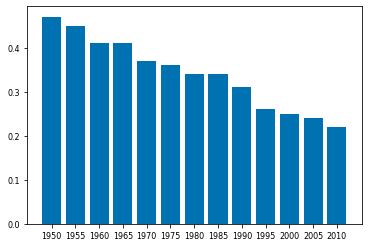

In [333]:
years = df_["Year"].unique().tolist()
se = {}

for year in years:
    current = df_.loc[df[df["Year"] == year].index]
    feature_nan_percentage = round(current.isnull().sum(axis=1).sum() / (len(current.columns) * current.shape[0]), 2)
    se[year] = feature_nan_percentage
    
names = list(se.keys())
values = list(se.values())

plt.bar(range(len(se)), values, tick_label=names)
plt.show()    

### Analisi per paese

Vengono mostrati i primi 10 paesi per percentuale di valori mancanti (NaN)

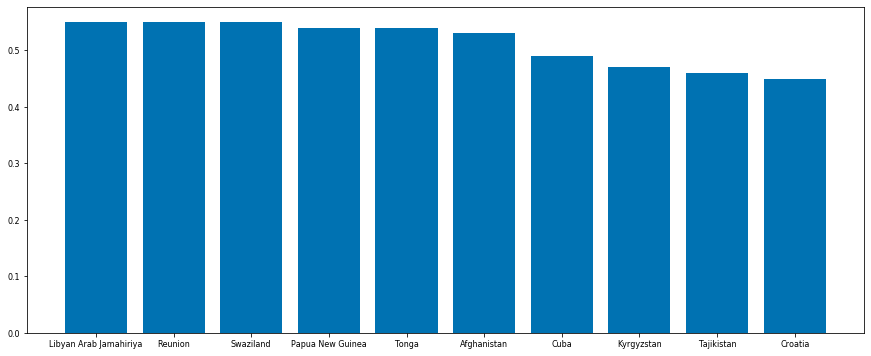

In [334]:
countries = df_["Country"].unique().tolist()
se = {}

for country in countries:
    current = df_.loc[df[df["Country"] == country].index]
    feature_nan_percentage = round(current.isnull().sum(axis=1).sum() / (len(current.columns) * current.shape[0]), 2)
    se[country] = feature_nan_percentage
    
se = dict(sorted(se.items(), key=lambda x: x[1], reverse=True))
    
names = list(se.keys())
values = list(se.values())

names_10 = names[0:10]
values_10 = values[0:10]

plt.figure(figsize=(15,6))
plt.rcParams.update({'font.size': 8})
plt.bar(range(len(names_10)), values_10, tick_label=names_10)
plt.show()    

A questo punto si ha un dataset con molti valori mancanti, tale dataset verrà quindi modificato ed aggiustato per ogni tipologia di analisi che si proporràdi volta in volta. Anche le tipologie di normalizzazione che si utilizzeranno dipenderanno dall'analisi stessa.

# Analisi attraverso regressione multivariata multipla

Tale analisi è la più generale, verranno utilizzati tutti i dati riguardo l'istruzione per ogni paese (senza raggruppamento in regioni), compresa le feature *Educational Expenditure*, per la quale verranno generati dati attraverso interpolazione temporale. L'utilizzo della feature *Educational Expenditure* comporta la rimozione dei campionamenti relativi agli anni dal '50 al 70'. Le varibili di output sarranno *GDPcapita* e *GDPworker* in quanto la feature *GDPhour* presenta valori nulli per troppi paesi (verrà utilizzata per analisi più specifiche).


La tipologia di normalizzazione utilizzata è detta **Robust Scaling** ed è una tecnica di standardizzazione che ridimensiona i dati tenendo conto della mediana e del range interquartile (IQR), anziché la media e la deviazione standard.

A questo punto si procederà utilizzando una regressione multivariata multipla per stimare i vari coefficenti che verranno poi testati utilizzando il test statistico F, esso infatti verifica se almeno una delle variabili indipendenti ha un impatto significativo sulle variabili dipendenti nel modello. Il test F confronta la somma dei quadrati delle deviazioni spiegate dal modello con la somma dei quadrati delle deviazioni non spiegate.

## Creazione dataset

In [380]:
df_1 = df.copy()

df_1 = df_1.loc[df_1[df_1["Year"] >= 1970].index]

toRemove = ["m8", "s8", "m4", "s4", "Pisa", "Region", "GDPhour", "TotalPop", "Employed"]
df_1.drop(toRemove, axis=1, inplace=True)

df_1.head()

,Country,Year,NoSchooling,PrimaryTotal,SecondaryTotal,TertiaryTotal,AvgYearsOfTotalSchooling,Population(+15),EducationalExpenditure,GDPcapita,GDPworker
4,Australia,1970,0.76,23.73,56.25,19.26,9.70,9057,NaN,24160.248069,56497.996139
5,Australia,1975,1.07,12.75,65.46,20.72,10.52,9865,NaN,25899.661722,60732.463913
6,Australia,1980,0.80,6.10,69.90,23.20,11.20,10937,5.64446,28314.323087,65800.057536
7,Australia,1985,1.12,7.80,67.54,23.48,11.20,11973,5.39562,30510.679399,71523.833504
8,Australia,1990,1.09,9.25,65.33,24.33,11.18,13178,4.66854,32738.451807,70774.945571


In [381]:
print(df_1.isnull().sum())

Country                       0
Year                          0
NoSchooling                   0
PrimaryTotal                  0
SecondaryTotal                0
TertiaryTotal                 0
AvgYearsOfTotalSchooling      0
Population(+15)               0
EducationalExpenditure      488
GDPcapita                   118
GDPworker                   166
dtype: int64


#### Gestione EducationalExpenditure

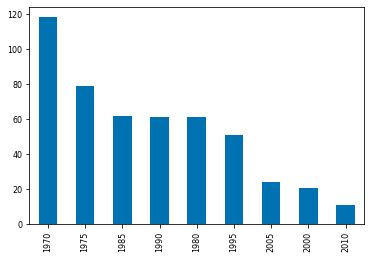

In [382]:
invalid = df_1.loc[pd.isna(df_1['EducationalExpenditure']), :].index

years = df_1.loc[invalid][["Year"]]["Year"]
years_count = years.value_counts()
# years.hist(bins=[1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010])
years_count.plot(kind='bar')

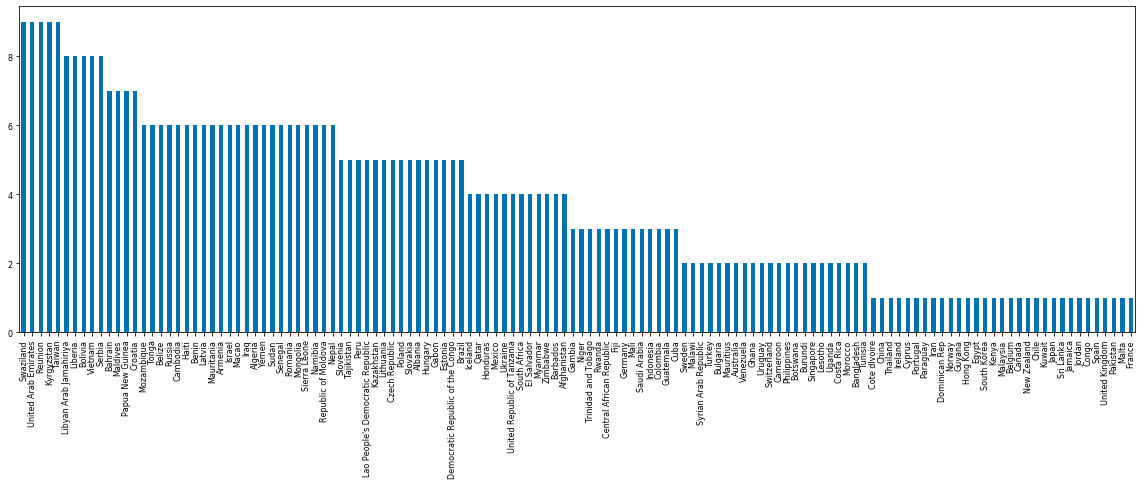

In [383]:
country = df_1.loc[invalid][["Country"]]["Country"]
counts = country.value_counts()

plt.figure(figsize=(20, 6))
plt.xticks(rotation='vertical')
counts.plot(kind='bar')

A Questo punto si procede selezionando i paesi con meno del 50% di valori NaN ed a questi verranno calcolati i valori mancanti attraverso interpolazione temporale, mentre i paesi con un tasso di valori mancanti superiore al 50% verranno scartati.

In [384]:
more_than_50_name = counts[counts >= 5].index.values.tolist()
less_than_50_name = counts[counts < 5].index.values.tolist()

indices_to_drop = df_1[df_1['Country'].isin(more_than_50_name)].index

df_1.drop(indices_to_drop, inplace=True)

In [385]:
for country in less_than_50_name:    
    country_data = df_1[df['Country'] == country]
    years = pd.to_datetime(country_data['Year'], format='%Y')
    values = country_data["EducationalExpenditure"]
    
    dff = pd.DataFrame({'Year': years, 'Value': values})
    dff.set_index('Year', inplace=True)
    
    dff['Value'] = dff['Value'].astype(float)
    dff['Value'] = dff['Value'].interpolate(method='time', limit_direction='both', limit=10)
    
    df_1.loc[df_1['Country'] == country, "EducationalExpenditure"] = dff['Value'].values

C:\Users\Alessandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### Gestione GDPcapita

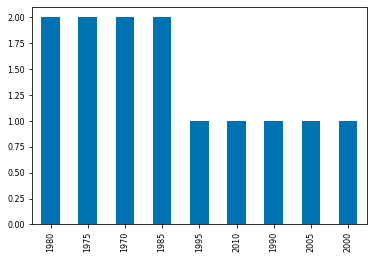

In [386]:
invalid = df_1.loc[pd.isna(df_1['GDPcapita']), :].index

years = df_1.loc[invalid][["Year"]]["Year"]
years_count = years.value_counts()
years_count.plot(kind='bar')

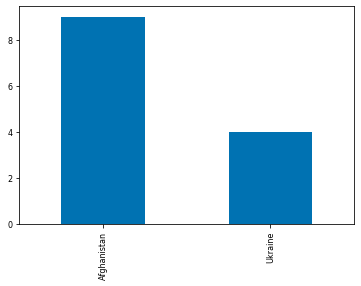

In [387]:
country = df_1.loc[invalid][["Country"]]["Country"]
counts = country.value_counts()

#plt.figure(figsize=(10, 6))
counts.plot(kind='bar')

In [388]:
indice_to_drop = df_1[df_1['Country'] == "Afghanistan"].index
df_1.drop(indice_to_drop, inplace=True)
indice_to_drop = df_1[df_1['Country'] == "Ukraine"].index
df_1.drop(indice_to_drop, inplace=True)
indice_to_drop = df_1[df_1['Country'] == "Cuba"].index
df_1.drop(indice_to_drop, inplace=True)

#### Gestione GDPworker

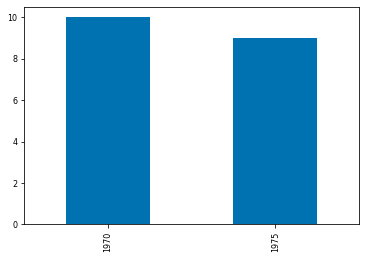

In [389]:
invalid = df_1.loc[pd.isna(df_1['GDPworker']), :].index

years = df_1.loc[invalid][["Year"]]["Year"]
years_count = years.value_counts()
years_count.plot(kind='bar')

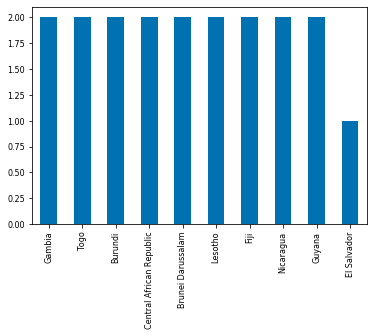

In [390]:
country = df_1.loc[invalid][["Country"]]["Country"]
counts = country.value_counts()

#plt.figure(figsize=(10, 6))
counts.plot(kind='bar')

In [391]:
for country in counts.index.values.tolist():    
    country_data = df_1[df['Country'] == country]
    years = pd.to_datetime(country_data['Year'], format='%Y')
    values = country_data["GDPworker"]
    
    dff = pd.DataFrame({'Year': years, 'Value': values})
    dff.set_index('Year', inplace=True)
    
    dff['Value'] = dff['Value'].astype(float)
    dff['Value'] = dff['Value'].interpolate(method='time', limit_direction='both', limit=10)
    
    df_1.loc[df_1['Country'] == country, "GDPworker"] = dff['Value'].values

C:\Users\Alessandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [392]:
print(df_1.isnull().sum())

Country                     0
Year                        0
NoSchooling                 0
PrimaryTotal                0
SecondaryTotal              0
TertiaryTotal               0
AvgYearsOfTotalSchooling    0
Population(+15)             0
EducationalExpenditure      0
GDPcapita                   0
GDPworker                   0
dtype: int64


In [396]:
df_2 = df_1.loc[df_1[df_1["Country"] == "Italy" ].index]

x = df_2[['NoSchooling', 'PrimaryTotal', 'SecondaryTotal', 'TertiaryTotal', 'AvgYearsOfTotalSchooling', 'Population(+15)', 'EducationalExpenditure']]
y = df_2['GDPworker']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 -3652639.1982871266
Coefficients: 
 [ 3.76824920e+04  3.80631444e+04  4.18893658e+04  3.96311546e+04
 -2.92770022e+04  4.55999551e-03 -9.06706237e+03]
                            OLS Regression Results                            
Dep. Variable:              GDPworker   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     571.9
Date:                Thu, 29 Jun 2023   Prob (F-statistic):             0.0322
Time:                        19:06:30   Log-Likelihood:                -62.969
No. Observations:                   9   AIC:                             141.9
Df Residuals:                       1   BIC:                             143.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err

C:\Users\Alessandro\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Alessandro\Anaconda3\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


In [ ]:
#plt.matshow(df_1.corr())
#plt.show()


plt.scatter(df_1['EducationalExpenditure'], df_1['GDPcapita'], color='red')
plt.title('Educational expenditure Vs GDP per worker', fontsize=14)
plt.xlabel('Educational expenditure', fontsize=14)
plt.ylabel('GDP per worker', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
corr = df_1.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


In [ ]:
https://www.focus.it/comportamento/economia/quanto-vale-il-capitale-umano-di-una-nazione